In [ ]:
# Import required libraries
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
import glob
from prophet import Prophet

# Define the pattern for multiple CSV files (assuming they follow a naming convention)
file_pattern = "BIN_001_data_*.csv"
csv_files = glob.glob(file_pattern)

# Loop through each CSV file and append its contents to the combined dataframe
dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]
data = pd.concat(dataframes)

# Print the combined dataframe
print(data)

       BinID  bin_level                              Time
0    BIN_001       0.00  2025-02-01T00:00:52.504823+08:00
1    BIN_001       0.01  2025-02-01T00:10:00.389791+08:00
2    BIN_001       0.10  2025-02-01T00:20:02.779582+08:00
3    BIN_001       0.20  2025-02-01T00:30:04.169373+08:00
4    BIN_001       0.27  2025-02-01T00:40:05.559164+08:00
..       ...        ...                               ...
357  BIN_001       3.83  2025-03-03T19:55:21.198582+08:00
358  BIN_001       4.26  2025-03-03T20:05:20.877673+08:00
359  BIN_001       3.40  2025-03-03T20:15:20.553905+08:00
360  BIN_001       4.26  2025-03-03T20:25:20.226877+08:00
361  BIN_001       4.26  2025-03-03T20:35:19.906722+08:00

[4227 rows x 3 columns]


In [ ]:
# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%S.%f+08:00')

# Set 'Time' as index
data.set_index('Time', drop=True, inplace=True)

# Ensure 'bin_level' is numeric, and handle errors gracefully
data['bin_level'] = pd.to_numeric(data['bin_level'], errors='coerce')

# Drop rows with NaN values (if any)
data.dropna(subset=['bin_level'], inplace=True)

# Print the cleaned data
print(data)

                              BinID  bin_level
Time                                          
2025-02-01 00:00:52.504823  BIN_001       0.00
2025-02-01 00:10:00.389791  BIN_001       0.01
2025-02-01 00:20:02.779582  BIN_001       0.10
2025-02-01 00:30:04.169373  BIN_001       0.20
2025-02-01 00:40:05.559164  BIN_001       0.27
...                             ...        ...
2025-03-03 19:55:21.198582  BIN_001       3.83
2025-03-03 20:05:20.877673  BIN_001       4.26
2025-03-03 20:15:20.553905  BIN_001       3.40
2025-03-03 20:25:20.226877  BIN_001       4.26
2025-03-03 20:35:19.906722  BIN_001       4.26

[4227 rows x 2 columns]


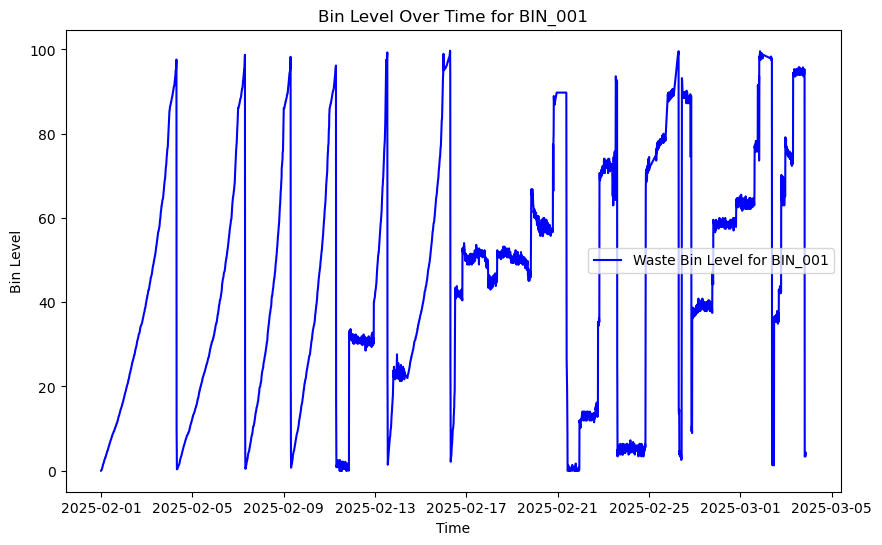

In [ ]:
# Get the first unique BinID from the dataset
bin_id = data['BinID'].unique()[0]  # Assuming 'data' is a pandas DataFrame containing bin data

# Filter data for the specific bin we're analyzing
bin_data = data[data['BinID'] == bin_id]

# Plot the historical bin level dataset
plt.figure(figsize=(10, 6))
plt.plot(bin_data.index, bin_data['bin_level'], label=f'Waste Bin Level for {bin_id}', color='blue')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Bin Level")
plt.title(f"Bin Level Over Time for {bin_id}")
plt.legend()

# Show the plot
plt.show()

21:57:04 - cmdstanpy - INFO - Chain [1] start processing
21:57:04 - cmdstanpy - INFO - Chain [1] done processing


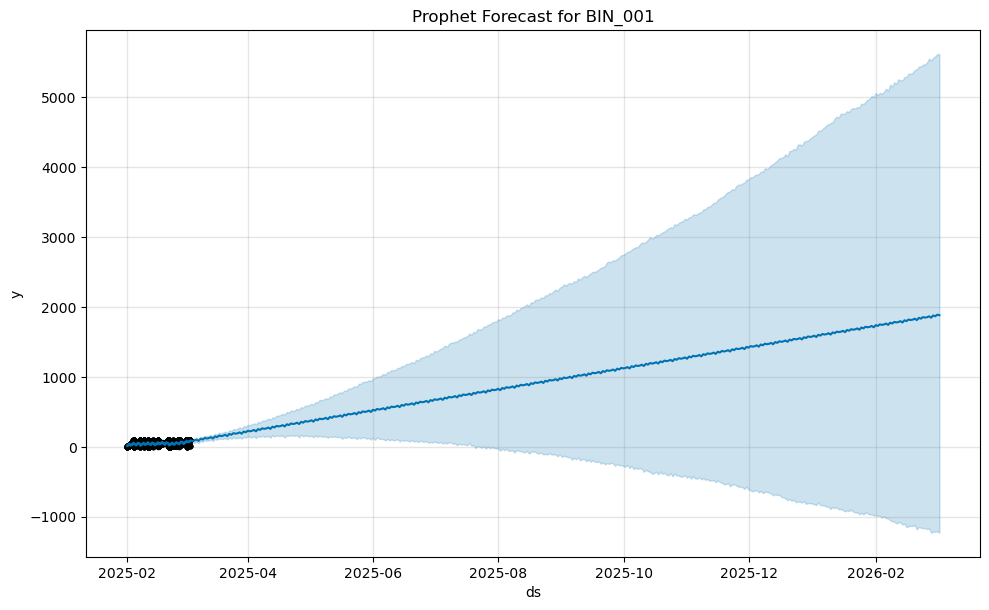

In [ ]:
# Prepare data for Prophet to ensure that Time is a column
prophet_data = bin_data.reset_index()[['Time', 'bin_level']].rename(columns={'Time': 'ds', 'bin_level': 'y'})

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future dataframe for Prophet
future = prophet_model.make_future_dataframe(periods=365)
prophet_forecast = prophet_model.predict(future)

# Plot Prophet forecast
prophet_model.plot(prophet_forecast)
plt.title(f"Prophet Forecast for {bin_id}")
plt.show()

# Decompose time series into trend and weekly
# Extract the trend and seasonality from Prophet
prophet_trend_seasonality = prophet_forecast[['ds', 'trend', 'weekly']].set_index('ds')

# Merge Prophet results with original data
combined_data = bin_data.join(prophet_trend_seasonality, how='left')

# Calculate residuals
combined_data['residual'] = combined_data['bin_level'] - combined_data['trend'] - combined_data['weekly']

# Prepare data for LSTM
residuals = combined_data['residual'].values

In [ ]:
# Convert the data values to numpy for better and faster processing 
time_index = np.array(combined_data.index)
data = np.array(residuals)

# ratio to split the data
SPLIT_RATIO = 0.7 

# Dividing into train-test split 
split_index = int(SPLIT_RATIO * data.shape[0])   

# Train-Test Split 
train_data = data[:split_index] 
train_time = time_index[:split_index]  
test_data = data[split_index:] 
test_time = time_index[split_index:]

In [ ]:
## required parameters
WINDOW_SIZE = 60 # Number of time steps used as input for prediction
BATCH_SIZE = 32 # Number of samples per batch
SHUFFLE_BUFFER = 1000 # Buffer size for shuffling data

## function to create the input features
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    '''
    Utility function for time series data generation in batches
    '''
    ts_data = tf.data.Dataset.from_tensor_slices(data)  # Convert data into TensorFlow dataset
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)  # Create sliding windows
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))  # Convert windows to batches
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))  # Split into (features, labels)
    ts_data = ts_data.batch(batch_size).prefetch(1)  # Batch data and prefetch for performance optimization
    return ts_data

# Expanding data into tensors

tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)

# Datanow has shape(samples, time_steps, 1).

## generate input and output features for training and testing datasets
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [ ]:
# Define LSTM neural network architecture for time series forecasting
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None, 1)),# Input shape: (time_steps, features)
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1) # Output layer (regression)
])

# Summary of model
model.summary()

In [ ]:
# Print dataset sizes for debugging and verification
print(f"Train data size: {len(train_data)}")  # Number of samples in training set
print(f"Test data size: {len(test_data)}")  # Number of samples in test set

Train data size: 2958
Test data size: 1269


In [ ]:
## compile neural network model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## traing neural network model
history = model.fit(tensor_train_dataset, epochs=200, validation_data=tensor_test_dataset)

Epoch 1/200
     91/Unknown 5s 25ms/step - loss: 15.3492 - mae: 15.8375

c:\Users\royte\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 15.3258 - mae: 15.8141 - val_loss: 17.9002 - val_mae: 18.3929
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.9567 - mae: 10.4351 - val_loss: 15.9412 - val_mae: 16.4303
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8586 - mae: 8.3307 - val_loss: 15.7386 - val_mae: 16.2258
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.8025 - mae: 8.2718 - val_loss: 15.5850 - val_mae: 16.0689
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.0459 - mae: 7.5118 - val_loss: 15.9391 - val_mae: 16.4235
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.8258 - mae: 7.2958 - val_loss: 15.9447 - val_mae: 16.4287
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 6.2372 - mae: 6.7015 - val_loss: 15.9346 - val_mae: 16.4210
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.7596 - mae: 7.2207 - val_loss: 16.4174 - val_mae: 16.9027
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/st

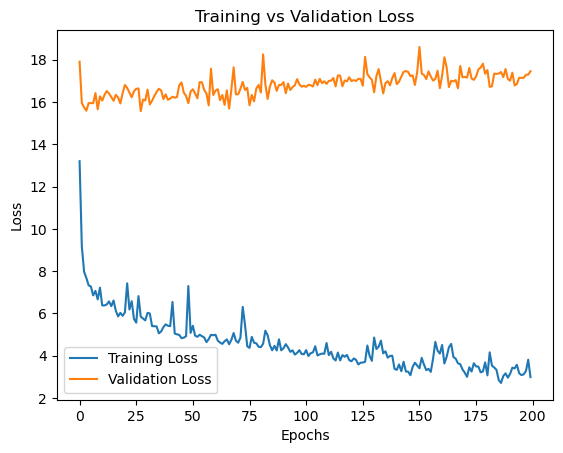

In [ ]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')  # Training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss over epochs
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training vs Validation Loss')  # Chart title
plt.legend()  # Show legend
plt.show()  # Display the plot


In [ ]:
# Function to forecast future values
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Forecast residuals using LSTM
lstm_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE)
lstm_forecast = lstm_forecast[split_index - WINDOW_SIZE:-1, -1, 0]

# Combine Prophet and LSTM forecasts
combined_forecast = prophet_forecast['yhat'].values[split_index:split_index + len(lstm_forecast)] + lstm_forecast

# Overall Error
error = tf.keras.metrics.MeanAbsoluteError()(test_data, lstm_forecast).numpy()
print(f"Combined Model MAE: {error}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Combined Model MAE: 9.059588432312012


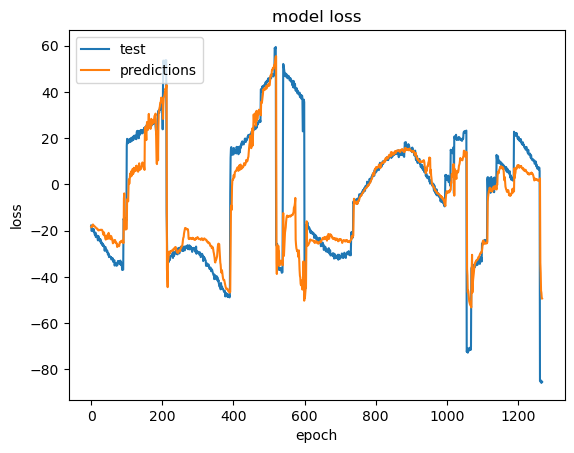

In [ ]:
# Plot actual vs predicted values
plt.plot(test_data, label='Actual Values')  # Plot actual test values
plt.plot(lstm_forecast, label='Model Predictions')  # Plot model predictions
plt.title('Model Performance on Test Data')  # Chart title
plt.ylabel('Bin Fill Level')  # Y-axis label
plt.xlabel('Time Steps')  # X-axis label
plt.legend(['Test Data', 'Predictions'], loc='upper left')  # Legend with position
plt.show()  # Display the plot

In [ ]:
# Extend the time index for future dates
N_FUTURE = 7 * 24 * 6 # Number of future days to predict
last_date = pd.to_datetime(test_time[-1])  # Last date in the test set
future_dates = [last_date + pd.Timedelta(minutes=10*i) for i in range(1, N_FUTURE + 1)]

# Prepare data for future forecasting
future_data = data[-WINDOW_SIZE:]  # Use the last 'WINDOW_SIZE' values for predictions

# Print future dates for which predictions were made
print(f"Future dates for 1 month prediction: {future_dates}")

Future dates for 1 month prediction: [Timestamp('2025-03-03 20:45:19.906722'), Timestamp('2025-03-03 20:55:19.906722'), Timestamp('2025-03-03 21:05:19.906722'), Timestamp('2025-03-03 21:15:19.906722'), Timestamp('2025-03-03 21:25:19.906722'), Timestamp('2025-03-03 21:35:19.906722'), Timestamp('2025-03-03 21:45:19.906722'), Timestamp('2025-03-03 21:55:19.906722'), Timestamp('2025-03-03 22:05:19.906722'), Timestamp('2025-03-03 22:15:19.906722'), Timestamp('2025-03-03 22:25:19.906722'), Timestamp('2025-03-03 22:35:19.906722'), Timestamp('2025-03-03 22:45:19.906722'), Timestamp('2025-03-03 22:55:19.906722'), Timestamp('2025-03-03 23:05:19.906722'), Timestamp('2025-03-03 23:15:19.906722'), Timestamp('2025-03-03 23:25:19.906722'), Timestamp('2025-03-03 23:35:19.906722'), Timestamp('2025-03-03 23:45:19.906722'), Timestamp('2025-03-03 23:55:19.906722'), Timestamp('2025-03-04 00:05:19.906722'), Timestamp('2025-03-04 00:15:19.906722'), Timestamp('2025-03-04 00:25:19.906722'), Timestamp('2025-03-

In [ ]:
# Function to forecast future values
def model_forecast_future(model, data, window_size, future_steps):
    forecast = []
    current_data = data
    for _ in range(future_steps):
        input_data = tf.expand_dims(current_data[-window_size:], axis=-1)
        prediction = model.predict(input_data[None, ...])[0, -1, 0]  # Predict the next value
        forecast.append(prediction)
        current_data = np.append(current_data, prediction)  # Add the prediction to the data
    return forecast

In [ ]:
# Forecast future values
future_steps = 7 * 24 * 6  # Number of 10-minute intervals in 1 week
future_residuals = model_forecast_future(model, data, WINDOW_SIZE, future_steps)

# Combine Prophet and LSTM forecasts for future dates
future_prophet = prophet_model.predict(prophet_model.make_future_dataframe(periods=future_steps, freq='10T'))
future_combined_forecast = future_prophet['yhat'].values[-future_steps:] + future_residuals

# Create DataFrame for future predictions
future_dates = pd.date_range(start=test_time[-1], periods=future_steps + 1, freq='10T')[1:]
future_df = pd.DataFrame({
    'BinID': bin_id,
    'Time': future_dates,
    'Predicted Waste Level': future_combined_forecast
})

# Cap predictions at a maximum value (e.g., 100)
max_capacity = 100
future_df['Predicted Waste Level'] = future_df['Predicted Waste Level'].clip(upper=max_capacity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

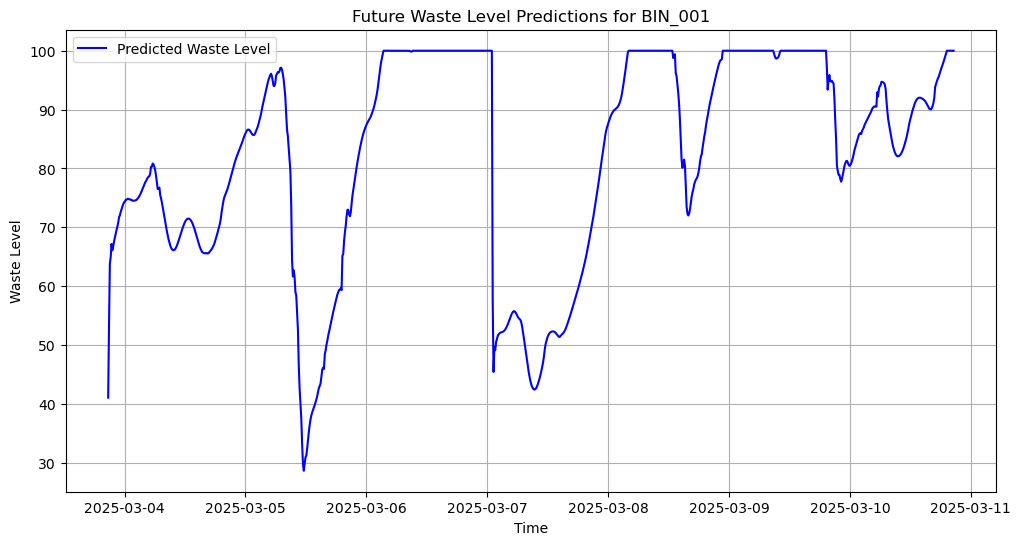

Future Forecast for BinID BIN_001:
        BinID                       Time  Predicted Waste Level
0     BIN_001 2025-03-03 20:45:19.906722              41.035127
1     BIN_001 2025-03-03 20:55:19.906722              53.317444
2     BIN_001 2025-03-03 21:05:19.906722              63.749542
3     BIN_001 2025-03-03 21:15:19.906722              64.943032
4     BIN_001 2025-03-03 21:25:19.906722              67.152680
...       ...                        ...                    ...
1003  BIN_001 2025-03-10 19:55:19.906722             100.000000
1004  BIN_001 2025-03-10 20:05:19.906722             100.000000
1005  BIN_001 2025-03-10 20:15:19.906722             100.000000
1006  BIN_001 2025-03-10 20:25:19.906722             100.000000
1007  BIN_001 2025-03-10 20:35:19.906722             100.000000

[1008 rows x 3 columns]


In [ ]:
# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_df['Time'], future_df['Predicted Waste Level'], label='Predicted Waste Level', color='blue')
plt.title(f"Future Waste Level Predictions for {bin_id}")
plt.xlabel("Time")
plt.ylabel("Waste Level")
plt.legend()
plt.grid(True)
plt.show()

# Print the future forecast
print("Future Forecast for BinID BIN_001:")
print(future_df)

In [ ]:
# Assuming the waste level has a known threshold, such as 80% of the maximum value
threshold = 80.00  # Adjust if you have a specific threshold

# Filter the future_df DataFrame for predicted values greater than 80%
exceed_threshold_df = future_df[future_df['Predicted Waste Level'] > threshold]

# Get only the first record where the waste level exceeds the threshold
first_exceed_time = exceed_threshold_df['Time'].values[0]


# Print the first record
print(f"BinID {bin_id} would be full again at: {first_exceed_time}") 


BinID BIN_001 would be full again at: 2025-03-04T05:15:19.906722000
